In [61]:
from sklearn.feature_selection import chi2
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from statsmodels.formula.api import ols

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import chi2_contingency
import math

import datetime
import calendar

from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.metrics import r2_score as r2

# For statistical tests
from scipy import stats
from sklearn.model_selection import train_test_split

# For visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm

cmap = cm.get_cmap('gnuplot')
pd.set_option('display.max_columns', None)


In [2]:
# dataset = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/Fraud_Data.csv")
# IP_table = pd.read_csv("https://raw.githubusercontent.com/KohSiXing/BT4012-Fraud-Analytics/master/IpAddress_to_Country.csv")

dataset = pd.read_csv('Fraud_Data.csv')
IP_table = pd.read_csv('IpAddress_to_Country.csv')

In [3]:
dataset["time"] = pd.DataFrame(pd.to_datetime(dataset["purchase_time"]) - pd.to_datetime(dataset["signup_time"])).astype(str)
dataset["time"] = dataset["time"].apply(lambda x : x[-8:])
dataset["time"] = pd.to_datetime(dataset['time'],format= '%H:%M:%S' ).dt.time
dataset["time"]

0         03:51:22
1         04:59:04
2         00:00:01
3         16:41:25
4         11:31:01
            ...   
151107    21:27:13
151108    18:41:10
151109    08:00:16
151110    13:28:39
151111    19:01:33
Name: time, Length: 151112, dtype: object

In [4]:
device_duplicates = pd.DataFrame(dataset.groupby(by = "device_id").device_id.count())  # at this moment, index column name and first column name both are equal to "device_id"
device_duplicates.rename(columns={"device_id": "freq_device"}, inplace=True)           # hence we need to replace the "device_id" column name
device_duplicates.reset_index(level=0, inplace= True)

In [5]:
IP_table.upper_bound_ip_address.astype("float")
IP_table.lower_bound_ip_address.astype("float")
dataset.ip_address.astype("float")

# function that takes an IP address as argument and returns country associated based on IP_table

def IP_to_country(ip) :
    try :
        return IP_table.country[(IP_table.lower_bound_ip_address < ip)                            
                                & 
                                (IP_table.upper_bound_ip_address > ip)].iloc[0]
    except IndexError :
        return "Unknown"     
dataset["IP_country"] = dataset.ip_address.apply(IP_to_country)

In [6]:
dataset = dataset.merge(device_duplicates, on= "device_id")

# --- 1 ---
# Categorisation column freq_device
# We see a clear correlation between freq_device and fraudulent activities. We are going to split freq_device in 7 categories
dataset.freq_device = dataset.freq_device.apply(lambda x :
                                                str(x) if x <5 else
                                                "5-10" if x>=5 and x<=10 else
                                                "11-15" if x>10 and x<=15 else
                                                "> 15")

# We convert signup_time and purchase_time en datetime

dataset.signup_time = pd.to_datetime(dataset.signup_time, format = '%Y-%m-%d %H:%M:%S')
dataset.purchase_time = pd.to_datetime(dataset.purchase_time, format = '%Y-%m-%d %H:%M:%S')

# We add features 

# --- 2 ---
# Column month
dataset["month_purchase"] = dataset.purchase_time.apply(lambda x: calendar.month_name[x.month])

# --- 3 ---
# Column week
dataset["weekday_purchase"] = dataset.purchase_time.apply(lambda x: calendar.day_name[x.weekday()])

# --- 4 ---
# Column hour_of_the_day
dataset["hour_of_the_day"] = dataset.purchase_time.apply(lambda x: x.hour)

# --- 5 ---
# Column seconds_since_signup
dataset["seconds_since_signup"]= (dataset.purchase_time - dataset.signup_time).apply(lambda x : x.total_seconds())

# --- 6 ---
# Column countries_from_device (ie. number of different countries per device_id)

# We flag devices that committed purchases from different countries
# First we groupby device_id and IP_country which will give us a DF with a sublist of country for each device_id
country_count = dataset.groupby(by =[ "device_id","IP_country"]).count().reset_index()

# Then we can count the number of different countries by device_id
country_count = pd.DataFrame(country_count.groupby(by="device_id").count().IP_country)

# Finally we can merge this to our main dataset
dataset = dataset.merge(country_count, left_on="device_id", right_index=True)
dataset.rename(columns={"IP_country_x": "IP_country" , "IP_country_y":"countries_from_device"}, inplace = True)

# --- 7 ---
# Column risk_country which classifies each country based on historical fraud rate from these countries

# We calculate the proportion of fraud by country
risk_country = pd.DataFrame(dataset.groupby(by="IP_country").mean()["class"].sort_values(ascending = False))

# We classify each country between Very High risk, High risk, Medium risk and low risk
risk_country["risk_country"] = risk_country["class"].apply(lambda x : 
                                                           "Very High risk" if x > 0.25 else
                                                           "High risk" if x > 0.05 else
                                                           "Medium risk" if x > 0.01 else
                                                           "Low risk")
                                                
# We merge with dataset
dataset = dataset.merge(risk_country.drop("class", axis = 1), left_on= "IP_country", right_index = True)

# --- 8 ---
# Column "quick_purchase" : categorise time between sign_up and purchase
dataset["quick_purchase"] = dataset.seconds_since_signup.apply(lambda x : 1 if x < 30 else 0)

# --- 9 ---
# Column freq_same_purchase : indicates how many times a given device_id purchased an item of the same value

# We generate a table indicating for each line if the couple device_id / purchase_value has duplicates
duplicate = dataset.duplicated(subset = ["purchase_value","device_id"], keep = False)
# We merge it with a DF containing purchase_value and device_id
duplicate = pd.concat([dataset.loc[:,["purchase_value","device_id"]], duplicate],axis=1)
# We build a DataFrame which gives us the number of duplicates for each combination of device_id / purchase_value
duplicate = duplicate.groupby(by = ["device_id","purchase_value"]).sum()
# We categorise number of time the same purchase has been made 
duplicate["freq_same_purchase"] = duplicate[0].apply(lambda x : 
                                                x if x < 5 else
                                                "5-10" if x<=10 else
                                                "11-15" if x<= 15 else
                                                ">15" 
                                               )
                                            
# We merge the result with main dataset            
dataset = dataset.merge(duplicate.drop(0,axis=1), left_on=["device_id","purchase_value"], right_index = True)

# --- 10 ---- 
# age categorisation

dataset["age_category"] = dataset.age.apply(lambda x : 
                 "< 40" if x < 40 else
                 "40 - 49" if x < 50 else
                 "50 -59" if x < 60 else
                 "60 - 69" if x < 70 else
                 " > 70")

# ---- 11 ----
# Hour of the day categorisation
dataset["period_of_the_day"] = dataset.hour_of_the_day.apply(lambda x : 
                                                             "late night" if x < 4 else
                                                             "early morning" if x < 8 else
                                                             "morning" if x < 12 else
                                                             "early arvo" if x < 16 else
                                                             "arvo" if x < 20 else
                                                             "evening"
                                                            )

In [7]:
dataset

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,month_purchase,weekday_purchase,hour_of_the_day,seconds_since_signup,countries_from_device,risk_country,quick_purchase,freq_same_purchase,age_category,period_of_the_day
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,April,Saturday,2,4506682.0,1,High risk,0,0,< 40,late night
61,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,April,Thursday,17,5959702.0,1,High risk,0,0,< 40,arvo
70,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,August,Monday,5,662649.0,1,High risk,0,0,40 - 49,early morning
84,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,January,Monday,12,82537.0,2,High risk,0,0,40 - 49,early arvo
91,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,...,September,Sunday,8,5951052.0,2,High risk,0,0,< 40,morning
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127261,40206,2015-02-19 20:21:17,2015-04-04 02:46:18,26,CIWJPLNHZBBDV,SEO,IE,F,23,3.277722e+09,...,April,Saturday,2,3738301.0,1,Low risk,0,0,< 40,late night
132261,369153,2015-01-26 19:36:24,2015-02-03 02:14:54,12,ALALTFKYSIFXH,Ads,Chrome,M,34,1.505370e+09,...,February,Tuesday,2,628710.0,1,Low risk,0,0,< 40,late night
135452,209282,2015-03-27 22:02:49,2015-06-03 05:25:51,18,KUZBDYGURFVSN,Ads,FireFox,F,24,3.314912e+09,...,June,Wednesday,5,5815382.0,1,Low risk,0,0,< 40,early morning
137201,193457,2015-05-02 15:27:48,2015-05-14 20:59:33,45,UZBDAROVIEOPM,SEO,FireFox,M,30,3.412259e+09,...,May,Thursday,20,1056705.0,1,Low risk,0,0,< 40,evening


### Benford Law

#### Benford (Purchase Value)

In [8]:
df_benford = dataset.copy()

In [9]:
df_benford['purchase_value'] = df_benford["purchase_value"].astype(str)
df_benford['first_digit'] = df_benford['purchase_value'].str.slice(0,1)
df_benford.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,weekday_purchase,hour_of_the_day,seconds_since_signup,countries_from_device,risk_country,quick_purchase,freq_same_purchase,age_category,period_of_the_day,first_digit
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Saturday,2,4506682.0,1,High risk,0,0,< 40,late night,3
61,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,Thursday,17,5959702.0,1,High risk,0,0,< 40,arvo,7
70,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,Monday,5,662649.0,1,High risk,0,0,40 - 49,early morning,5
84,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,Monday,12,82537.0,2,High risk,0,0,40 - 49,early arvo,6
91,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,...,Sunday,8,5951052.0,2,High risk,0,0,< 40,morning,3


In [10]:
# Add in a new column containing the probabilities in Benford's Law
temp = (df_benford["first_digit"].value_counts()/len(df_benford) * 100).reset_index().sort_values(by=["index"])

temp = temp.reset_index().sort_values(by=["index"])

# Benford Law
temp = pd.concat([temp, pd.DataFrame([(math.log10(1 + (1/x)) * 100) for x in range(1,10)])], axis = 1)

temp = temp.drop(columns = ["level_0"])

temp.columns = ["First Digit", "Actual Proportion", "Benford's Law"]

temp

,First Digit,Actual Proportion,Benford's Law
0,1,17.881439,30.103000
1,2,20.512600,17.609126
2,3,19.792604,12.493874
3,4,16.630711,9.691001
4,5,11.525888,7.918125
5,6,6.876357,6.694679
6,7,3.341230,5.799195
7,8,1.414845,5.115252
8,9,2.024326,4.575749


In [11]:
bf_law_df = pd.melt(temp, id_vars="First Digit", var_name="Type", value_name="Probability")
bf_law_df

,First Digit,Type,Probability
0,1,Actual Proportion,17.881439
1,2,Actual Proportion,20.512600
2,3,Actual Proportion,19.792604
3,4,Actual Proportion,16.630711
4,5,Actual Proportion,11.525888
5,6,Actual Proportion,6.876357
6,7,Actual Proportion,3.341230
7,8,Actual Proportion,1.414845
8,9,Actual Proportion,2.024326
9,1,Benford's Law,30.103000


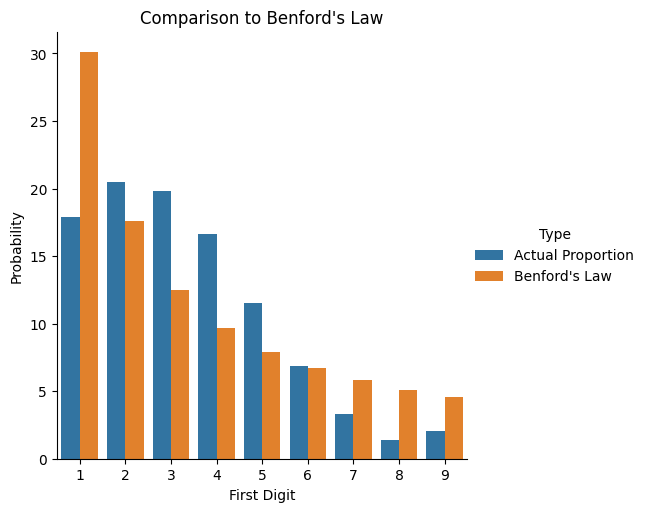

In [12]:
plot = sns.catplot(x='First Digit', y='Probability', hue='Type', data=bf_law_df, kind='bar').set(title = "Comparison to Benford's Law")
plot.fig.set_dpi(100)

#### Benford (user_id)

In [13]:
df_benford = dataset.copy()

In [14]:
df_benford['user_id'] = df_benford["user_id"].astype(str)
df_benford['first_digit'] = df_benford['user_id'].str.slice(0,1)
df_benford.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,...,weekday_purchase,hour_of_the_day,seconds_since_signup,countries_from_device,risk_country,quick_purchase,freq_same_purchase,age_category,period_of_the_day,first_digit
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,...,Saturday,2,4506682.0,1,High risk,0,0,< 40,late night,2
61,243817,2015-02-13 18:16:05,2015-04-23 17:44:27,72,YIIEFBZUGEXNR,Direct,Chrome,F,32,2.521871e+09,...,Thursday,17,5959702.0,1,High risk,0,0,< 40,arvo,2
70,81113,2015-08-16 12:56:45,2015-08-24 05:00:54,52,BKQVBSSFGETUQ,Direct,Chrome,F,44,3.682312e+09,...,Monday,5,662649.0,1,High risk,0,0,40 - 49,early morning,8
84,103087,2015-01-04 13:22:11,2015-01-05 12:17:48,67,ZTORJKTDMYTJH,Direct,IE,F,49,3.665105e+09,...,Monday,12,82537.0,2,High risk,0,0,40 - 49,early arvo,1
91,83866,2015-07-13 11:14:18,2015-09-20 08:18:30,33,JQYCFABXAMQVP,SEO,Chrome,F,34,7.359961e+08,...,Sunday,8,5951052.0,2,High risk,0,0,< 40,morning,8


In [15]:
# Add in a new column containing the probabilities in Benford's Law
temp = (df_benford["first_digit"].value_counts()/len(df_benford) * 100).reset_index().sort_values(by=["index"])

temp = temp.reset_index().sort_values(by=["index"])

# Benford Law
temp = pd.concat([temp, pd.DataFrame([(math.log10(1 + (1/x)) * 100) for x in range(1,10)])], axis = 1)

temp = temp.drop(columns = ["level_0"])

temp.columns = ["First Digit", "Actual Proportion", "Benford's Law"]

temp

,First Digit,Actual Proportion,Benford's Law
0,1,27.900498,30.103000
1,2,27.734396,17.609126
2,3,27.804542,12.493874
3,4,2.739028,9.691001
4,5,2.737043,7.918125
5,6,2.766160,6.694679
6,7,2.735719,5.799195
7,8,2.778072,5.115252
8,9,2.804542,4.575749


In [16]:
bf_law_df = pd.melt(temp, id_vars="First Digit", var_name="Type", value_name="Probability")
bf_law_df

,First Digit,Type,Probability
0,1,Actual Proportion,27.900498
1,2,Actual Proportion,27.734396
2,3,Actual Proportion,27.804542
3,4,Actual Proportion,2.739028
4,5,Actual Proportion,2.737043
5,6,Actual Proportion,2.766160
6,7,Actual Proportion,2.735719
7,8,Actual Proportion,2.778072
8,9,Actual Proportion,2.804542
9,1,Benford's Law,30.103000


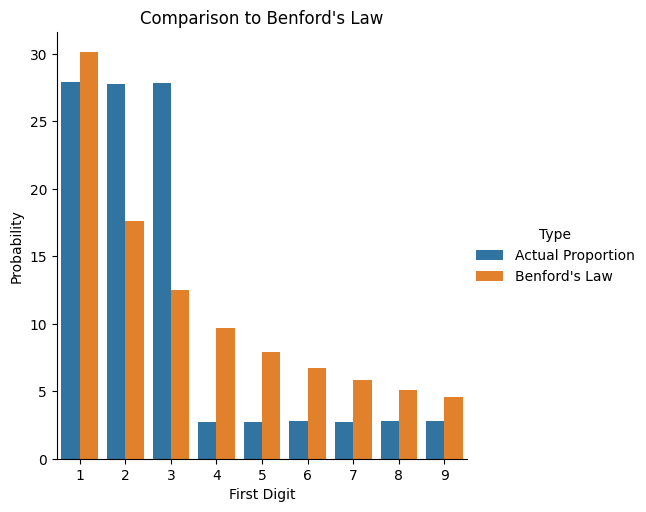

In [17]:
plot = sns.catplot(x='First Digit', y='Probability', hue='Type', data=bf_law_df, kind='bar').set(title = "Comparison to Benford's Law")
plot.fig.set_dpi(100)

### Box Plot (Purchase Value VS Class)

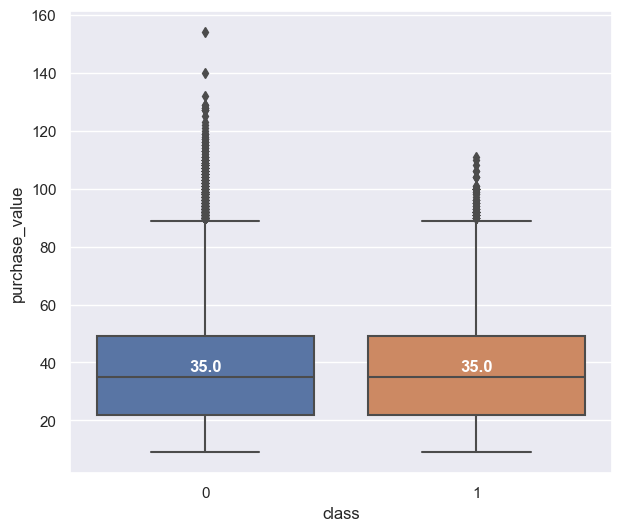

In [19]:
sns.set(rc={'figure.figsize':(7,6)})
box_plot = sns.boxplot(data=dataset , y='purchase_value', x='class')
medians = dataset.groupby(['class'])['purchase_value'].median()
vertical_offset = dataset['purchase_value'].median() * 0.05 # offset from median for display

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,medians[xtick] + vertical_offset,medians[xtick], 
            horizontalalignment='center',size='medium',color='w',weight='semibold')

Both boxplots have the similar shape and they also have the same median. 
Non fraudulent cases tend to have higher outliers.

## Check for correlation between risk_country v all countries

remove all countries since they are correlated with risk_country. Verified with chi2 contingency

In [20]:
datasetCR = dataset[['IP_country', 'risk_country']].groupby(['IP_country', 'risk_country']).size()
datasetCR

IP_country             risk_country  
Afghanistan            High risk           6
Albania                Low risk           13
Algeria                High risk         122
Angola                 Medium risk        24
Antigua and Barbuda    Low risk            3
                                        ... 
Viet Nam               High risk         550
Virgin Islands (U.S.)  Very High risk      3
Yemen                  Low risk            1
Zambia                 Low risk           10
Zimbabwe               Low risk            6
Length: 182, dtype: int64

In [21]:
datasetCR = datasetCR.unstack().fillna(0)
datasetCR = datasetCR.transpose() 
datasetCR

IP_country,Afghanistan,Albania,Algeria,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,Azerbaijan,...,Unknown,Uruguay,Uzbekistan,Vanuatu,Venezuela,Viet Nam,Virgin Islands (U.S.),Yemen,Zambia,Zimbabwe
risk_country,,,,,,,,,,,,,,,,,,,,,
High risk,6.0,0.0,122.0,0.0,0.0,661.0,15.0,1844.0,435.0,23.0,...,21966.0,80.0,10.0,0.0,251.0,550.0,0.0,0.0,0.0,0.0
Low risk,0.0,13.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10.0,6.0
Medium risk,0.0,0.0,0.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Very High risk,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0


<AxesSubplot:xlabel='IP_country', ylabel='risk_country'>

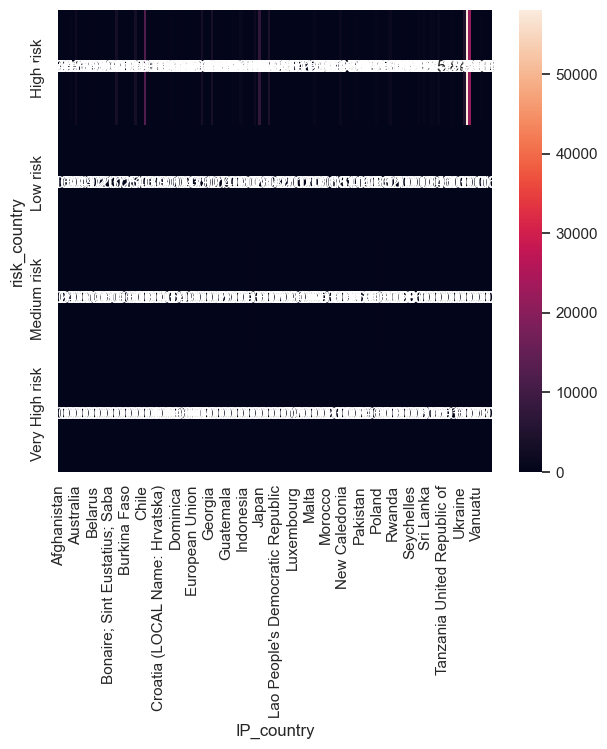

In [22]:
sns.heatmap(datasetCR, annot=True)

In [23]:
dataset.risk_country.unique()

array(['High risk', 'Very High risk', 'Medium risk', 'Low risk'],
      dtype=object)

In [24]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(datasetCR) 
# Print the p-value
print("p value\t\t\t", p)

print("Chi2 Contingency\t", c)

p value			 0.0
Chi2 Contingency	 453336.0


## Check for correlated variables with various numerical variables as dependent variable

In [25]:
model = ols('purchase_value ~ age_category + ip_address + seconds_since_signup + hour_of_the_day + month_purchase + weekday_purchase + risk_country + period_of_the_day + sex + quick_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.860848e+03,465.211876,1.385890,0.235933
month_purchase,11.0,5.592780e+03,508.434589,1.514652,0.118319
weekday_purchase,6.0,3.353721e+03,558.953496,1.665151,0.125044
risk_country,3.0,7.147424e+02,238.247453,0.709751,0.546019
period_of_the_day,5.0,5.600741e+03,1120.148159,3.336978,0.005139
sex,1.0,1.926256e+02,192.625635,0.573841,0.448738
ip_address,1.0,5.010593e+00,5.010593,0.014927,0.902760
seconds_since_signup,1.0,2.002911e+01,20.029110,0.059668,0.807022
hour_of_the_day,1.0,4.724492e+01,47.244915,0.140745,0.707542
quick_purchase,1.0,1.000730e+03,1000.730053,2.981225,0.084238


In [26]:
model = ols('seconds_since_signup ~ age_category + ip_address + purchase_value + hour_of_the_day + month_purchase + weekday_purchase + risk_country + period_of_the_day + sex + quick_purchase', data = dataset).fit()               
sm.stats.anova_lm(model, typ=1)

,df,sum_sq,mean_sq,F,PR(>F)
age_category,4.0,1.612254e+13,4.030634e+12,0.636547,6.363854e-01
month_purchase,11.0,5.186753e+17,4.715230e+16,7446.633220,0.000000e+00
weekday_purchase,6.0,3.827906e+13,6.379844e+12,1.007551,4.181384e-01
risk_country,3.0,6.529903e+12,2.176634e+12,0.343750,7.936911e-01
period_of_the_day,5.0,3.235919e+13,6.471838e+12,1.022080,4.025605e-01
sex,1.0,1.023447e+13,1.023447e+13,1.616301,2.036102e-01
ip_address,1.0,3.094208e+12,3.094208e+12,0.488660,4.845268e-01
purchase_value,1.0,3.783946e+11,3.783946e+11,0.059759,8.068779e-01
hour_of_the_day,1.0,6.905715e+12,6.905715e+12,1.090601,2.963398e-01
quick_purchase,1.0,1.473478e+15,1.473478e+15,232.702363,1.679680e-52


## XGBoost


In [27]:
cat_encoded = pd.get_dummies(dataset[['source', 'browser', 'sex', 'month_purchase', 'weekday_purchase',
        'countries_from_device',
       'risk_country', 'quick_purchase', 'age_category', 'period_of_the_day', 'freq_same_purchase']])
numerical = dataset[['purchase_value', 'seconds_since_signup', 'age']]

data = pd.concat([cat_encoded, numerical], axis = 1)



In [28]:
X = data
y = dataset[['class']]

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [30]:
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot


In [31]:
import re

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

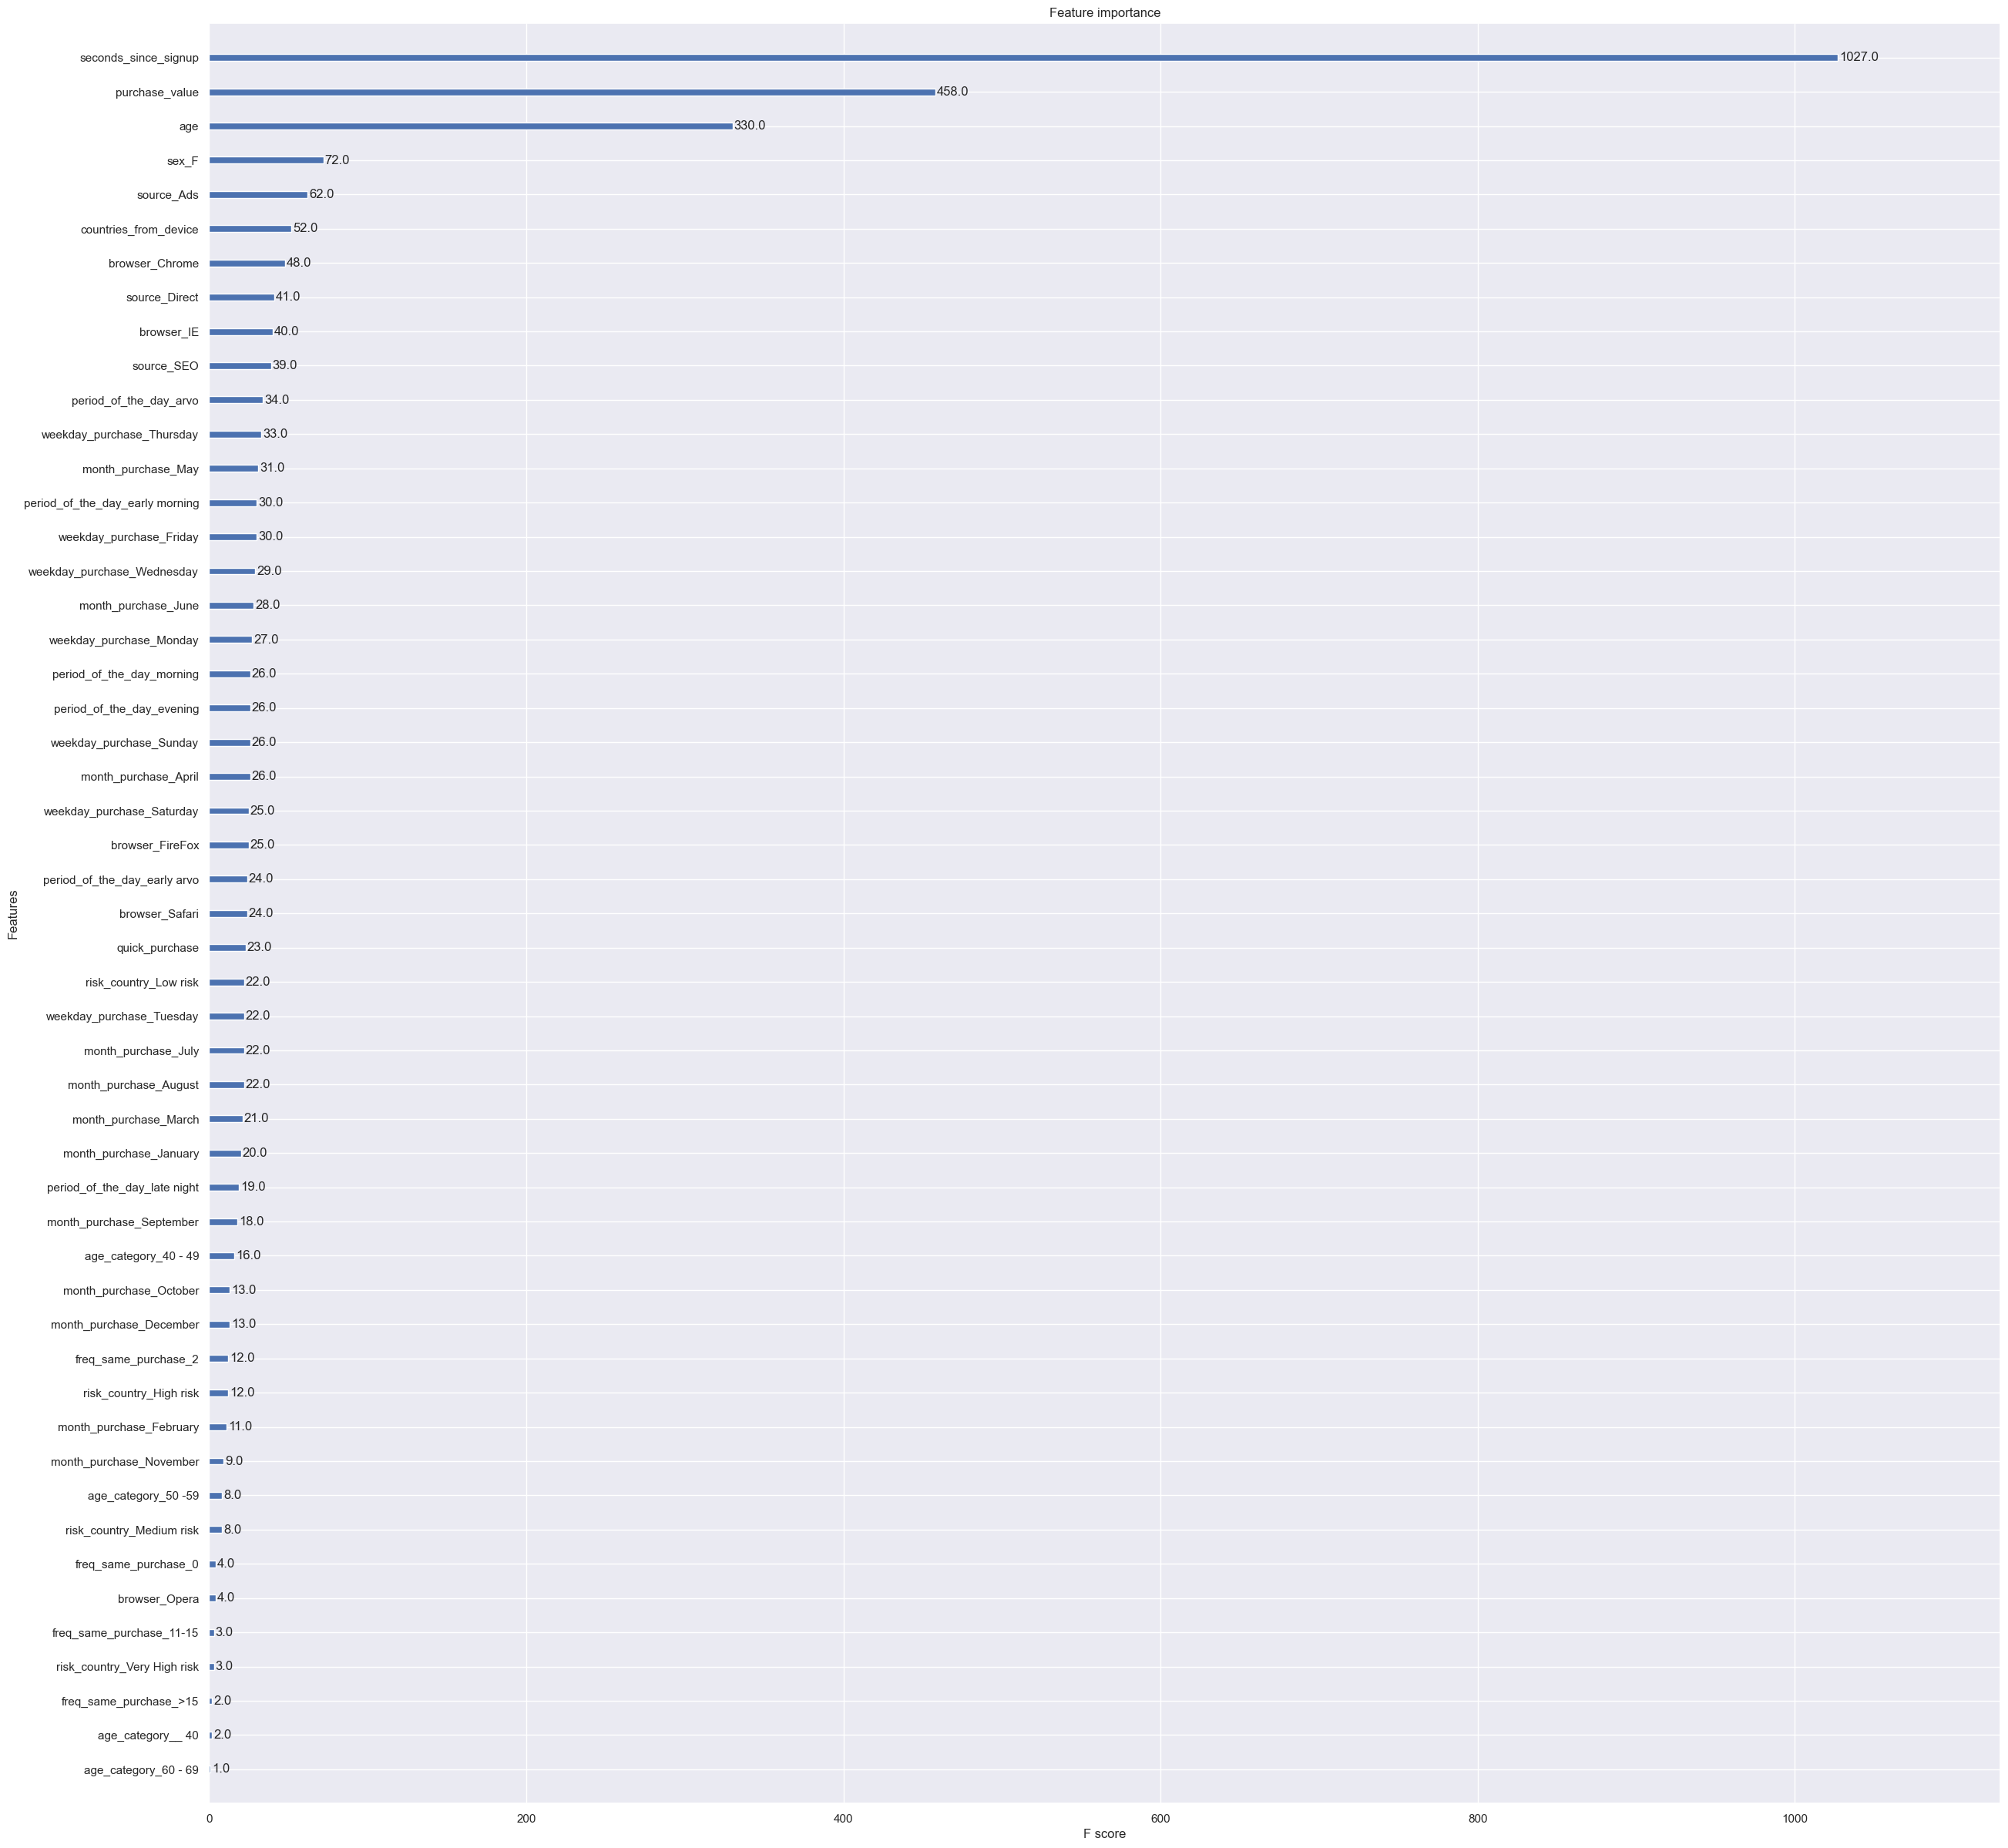

In [32]:
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plt.rcParams['figure.figsize'] = [30, 30]
display(plot_importance(model))

## RFE

In [33]:
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeClassifier
selector = RFE(estimator = DecisionTreeClassifier(), n_features_to_select=13, step=1)
selector = selector.fit(X_train, y_train)

selector.ranking_

array([ 1, 43, 19, 20, 23,  1,  1,  1, 26,  5, 14,  1,  8, 24, 34, 22, 32,
       11, 12, 18,  6, 27, 16,  9,  1, 21,  4, 10, 13,  2,  1, 31, 40, 36,
       37, 44, 17, 28, 38, 25,  3,  7,  1, 15,  1,  1, 29, 30, 42, 41, 33,
       35, 39,  1,  1,  1])

In [34]:
ranking = pd.DataFrame([1, 43, 18, 20, 23,  1,  2,  1, 25,  4,  1, 13,  5, 24, 36, 22, 31,
       12, 10, 17, 14, 27, 16,  7,  1, 19,  1,  9, 15,  3,  1, 32, 39, 37,
       35, 44, 21, 28, 40, 26,  1,  8, 11,  6,  1,  1, 29, 30, 42, 41, 33,
       34, 38,  1,  1,  1], columns=["ranking"])
features = pd.DataFrame(['countries_from_device', 'quick_purchase', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'month_purchase_April', 'month_purchase_August',
       'month_purchase_December', 'month_purchase_February',
       'month_purchase_January', 'month_purchase_July', 'month_purchase_June',
       'month_purchase_March', 'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High risk',
       'risk_country_Low risk', 'risk_country_Medium risk',
       'risk_country_Very High risk', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category__ 40', 'period_of_the_day_arvo',
       'period_of_the_day_early arvo', 'period_of_the_day_early morning',
       'period_of_the_day_evening', 'period_of_the_day_late night',
       'period_of_the_day_morning', 'freq_same_purchase_0.0',
       'freq_same_purchase_2.0', 'freq_same_purchase_3.0',
       'freq_same_purchase_4.0', 'freq_same_purchase_11-15',
       'freq_same_purchase_5-10', 'freq_same_purchase_>15', 'purchase_value',
       'seconds_since_signup', 'age'], columns = ['features'])
feat_df = pd.concat([ranking, features], axis = 1)

In [35]:
rslt_df = feat_df.loc[feat_df['ranking'] == 1]

In [36]:
rslt_df

,ranking,features
0,1,countries_from_device
5,1,browser_Chrome
7,1,browser_IE
10,1,sex_F
24,1,weekday_purchase_Friday
26,1,weekday_purchase_Saturday
30,1,weekday_purchase_Wednesday
40,1,period_of_the_day_arvo
44,1,period_of_the_day_late night
45,1,period_of_the_day_morning


## Select the relevant columns for building the model

In [37]:
final_df_X = data[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'period_of_the_day_arvo',
        'purchase_value', 'seconds_since_signup']]

In [38]:
final_df_y = dataset[['class']]

In [39]:
data.columns

Index(['countries_from_device', 'quick_purchase', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_FireFox',
       'browser_IE', 'browser_Opera', 'browser_Safari', 'sex_F', 'sex_M',
       'month_purchase_April', 'month_purchase_August',
       'month_purchase_December', 'month_purchase_February',
       'month_purchase_January', 'month_purchase_July', 'month_purchase_June',
       'month_purchase_March', 'month_purchase_May', 'month_purchase_November',
       'month_purchase_October', 'month_purchase_September',
       'weekday_purchase_Friday', 'weekday_purchase_Monday',
       'weekday_purchase_Saturday', 'weekday_purchase_Sunday',
       'weekday_purchase_Thursday', 'weekday_purchase_Tuesday',
       'weekday_purchase_Wednesday', 'risk_country_High risk',
       'risk_country_Low risk', 'risk_country_Medium risk',
       'risk_country_Very High risk', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
 

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df_X, final_df_y, test_size=0.30, random_state=42)

In [41]:
X_train

,countries_from_device,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_Safari,sex_F,weekday_purchase_Thursday,age_category_ > 70,age_category_40 - 49,age_category_50 -59,age_category_60 - 69,age_category_< 40,period_of_the_day_arvo,purchase_value,seconds_since_signup
84579,1,0,0,1,0,0,0,0,0,0,0,0,1,0,44,2993371.0
107117,1,0,0,1,1,0,1,0,0,1,0,0,0,0,28,9026734.0
35677,2,1,0,0,1,0,0,0,0,0,0,0,1,0,67,7268453.0
118485,1,0,0,1,1,0,0,0,0,0,0,0,1,0,24,10226468.0
20376,1,1,0,0,1,0,0,0,0,1,0,0,0,0,12,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50683,2,0,0,1,0,1,0,1,0,0,0,0,1,0,40,8657445.0
67590,1,0,1,0,0,1,0,0,0,0,0,0,1,0,40,3396055.0
122955,1,0,1,0,0,0,0,0,0,1,0,0,0,0,50,9152217.0
137829,1,0,0,1,0,0,0,0,0,0,0,0,1,0,76,1911779.0


In [42]:
rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy")

rfc.fit(X_train, y_train)

rfc.decision_path(X_train)

C:\Users\J\AppData\Local\Temp\ipykernel_15720\1880976047.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rfc.fit(X_train, y_train)


(<105778x1429600 sparse matrix of type '<class 'numpy.int64'>'
 	with 211424914 stored elements in Compressed Sparse Row format>,
 array([      0,   14457,   28974,   43403,   57652,   72067,   86248,
         100503,  114402,  128717,  142772,  156285,  170880,  184835,
         198954,  213349,  227308,  241439,  255740,  269631,  284960,
         299483,  314284,  328485,  343408,  357471,  372612,  386879,
         401456,  415411,  429252,  443793,  457692,  472023,  486284,
         501427,  515402,  530381,  544300,  558219,  572444,  586721,
         600808,  615419,  629652,  644151,  658436,  672701,  686758,
         701259,  715630,  729745,  743784,  758415,  772644,  786917,
         801048,  816045,  830364,  844407,  858266,  872485,  887996,
         902743,  916546,  930859,  944848,  958863,  973262,  987281,
        1001304, 1015899, 1030220, 1044621, 1058624, 1073125, 1087556,
        1102043, 1116182, 1130425, 1144648, 1158945, 1173470, 1187839,
        1201768, 1

In [43]:
y_pred = rfc.predict(X_test)

from sklearn import metrics 

# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

ACCURACY OF THE MODEL:  0.9490889839855297


In [44]:
## Other metrics

print("f1 score OF THE MODEL: ", metrics.accuracy_score(y_test, y_pred))

f1 score OF THE MODEL:  0.9490889839855297


### Chi Square Test (Cat vs Cat)

In [64]:
data.head()

,countries_from_device,quick_purchase,source_Ads,source_Direct,source_SEO,browser_Chrome,browser_FireFox,browser_IE,browser_Opera,browser_Safari,sex_F,sex_M,month_purchase_April,month_purchase_August,month_purchase_December,month_purchase_February,month_purchase_January,month_purchase_July,month_purchase_June,month_purchase_March,month_purchase_May,month_purchase_November,month_purchase_October,month_purchase_September,weekday_purchase_Friday,weekday_purchase_Monday,weekday_purchase_Saturday,weekday_purchase_Sunday,weekday_purchase_Thursday,weekday_purchase_Tuesday,weekday_purchase_Wednesday,risk_country_High risk,risk_country_Low risk,risk_country_Medium risk,risk_country_Very High risk,age_category_ > 70,age_category_40 - 49,age_category_50 -59,age_category_60 - 69,age_category_< 40,period_of_the_day_arvo,period_of_the_day_early arvo,period_of_the_day_early morning,period_of_the_day_evening,period_of_the_day_late night,period_of_the_day_morning,freq_same_purchase_0,freq_same_purchase_2,freq_same_purchase_3,freq_same_purchase_4,freq_same_purchase_11-15,freq_same_purchase_5-10,freq_same_purchase_>15,purchase_value,seconds_since_signup,age
0,1,0,0,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,34,4506682.0,39
61,1,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,72,5959702.0,32
70,1,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,52,662649.0,44
84,2,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,67,82537.0,49
91,2,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,33,5951052.0,34


In [65]:
cat_vars = [
    'source_Ads', 'source_Direct', 'source_SEO', 'browser_Chrome', 'browser_Safari', 'sex_F', 'weekday_purchase_Thursday', 'age_category_ > 70', 
    'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69','age_category_< 40', 'period_of_the_day_arvo',
    ]
    
num_vars = ['countries_from_device', 'purchase_value', 'seconds_since_signup']

x = ['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'period_of_the_day_arvo',
        'purchase_value', 'seconds_since_signup']


In [70]:
p_values = []
chai_stats = []
for cat1 in cat_vars:
    for cat2 in cat_vars:
            crosstab = pd.crosstab(data[cat1], data[cat2])
            chai2, p_val, _, _ = stats.chi2_contingency(crosstab)
            p_values.append((cat1, cat2, p_val))
            chai_stats.append((cat1, cat2, chai2))

chisquare = pd.DataFrame(p_values, columns=['Categorical 1', 'Categorical 2', 'p-value'])
chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value')

Categorical 2,age_category_ > 70,age_category_40 - 49,age_category_50 -59,age_category_60 - 69,age_category_< 40,browser_Chrome,browser_Safari,period_of_the_day_arvo,sex_F,source_Ads,source_Direct,source_SEO,weekday_purchase_Thursday
Categorical 1,,,,,,,,,,,,,
age_category_ > 70,0.000000e+00,3.029295e-01,1.000000e+00,1.000000e+00,3.417567e-07,0.914181,1.000000,0.376163,1.000000,0.963895,0.164399,0.450235,0.454209
age_category_40 - 49,3.029295e-01,0.000000e+00,7.633076e-295,5.064812e-22,0.000000e+00,0.791410,0.815478,0.581859,0.202494,0.095534,0.384235,0.017138,0.308847
age_category_50 -59,1.000000e+00,7.633076e-295,0.000000e+00,1.648559e-04,0.000000e+00,0.274124,0.029245,0.316238,0.638514,0.048215,1.000000,0.048077,0.048300
age_category_60 - 69,1.000000e+00,5.064812e-22,1.648559e-04,0.000000e+00,1.275374e-293,0.408254,0.166818,0.741492,0.936471,0.183552,1.000000,0.185871,0.362758
age_category_< 40,3.417567e-07,0.000000e+00,0.000000e+00,1.275374e-293,0.000000e+00,0.391709,0.359618,0.895348,0.156141,0.406629,0.399899,0.127329,0.052721
browser_Chrome,9.141806e-01,7.914103e-01,2.741243e-01,4.082544e-01,3.917085e-01,0.000000,0.000000,0.437667,0.835759,0.715044,0.000276,0.008988,0.368526
browser_Safari,1.000000e+00,8.154776e-01,2.924522e-02,1.668185e-01,3.596182e-01,0.000000,0.000000,0.189722,0.523753,0.719170,0.046143,0.045368,0.023199
period_of_the_day_arvo,3.761631e-01,5.818588e-01,3.162380e-01,7.414920e-01,8.953479e-01,0.437667,0.189722,0.000000,0.549670,0.894604,0.106003,0.235483,0.087773
sex_F,1.000000e+00,2.024941e-01,6.385143e-01,9.364713e-01,1.561406e-01,0.835759,0.523753,0.549670,0.000000,0.938092,0.498873,0.523850,0.951839


Text(0.5, 1.0, 'Correlation Heatmap (Cat vs Cat - Chi-square test)')

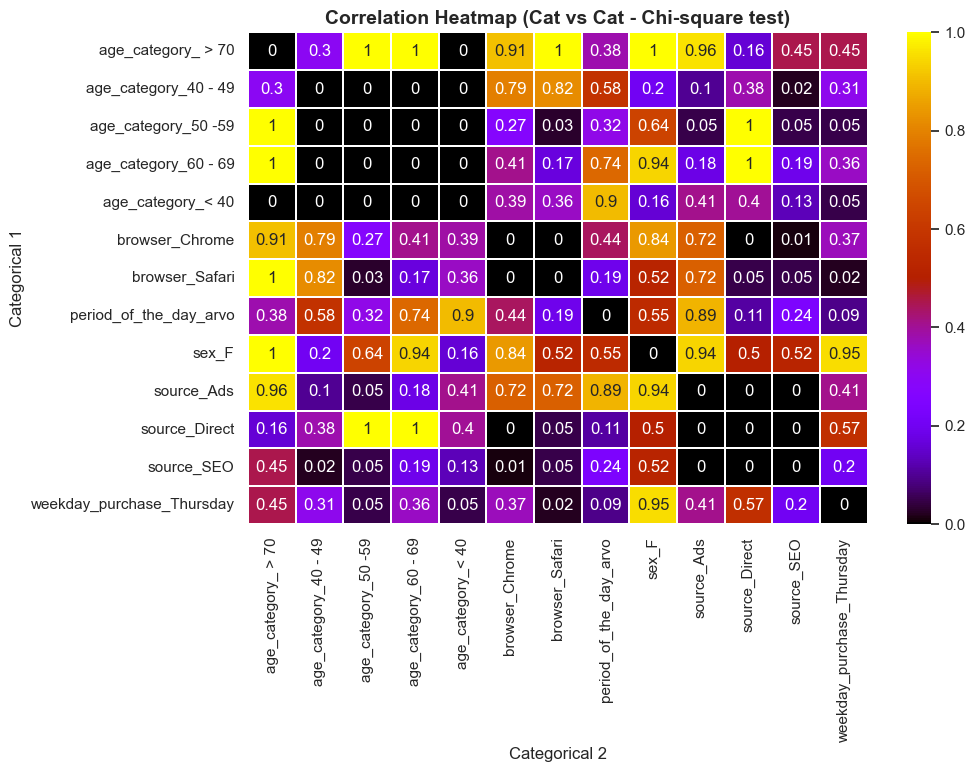

In [71]:
fig, ax = plt.subplots(1,1, figsize=(10,6))

hm = sns.heatmap(round(chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value'),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap=cmap, # Color Map.
                 annot=True, 
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

plt.title('Correlation Heatmap (Cat vs Cat - Chi-square test)', fontsize=14, fontweight='bold')

<AxesSubplot:xlabel='Categorical 2', ylabel='Categorical 1'>

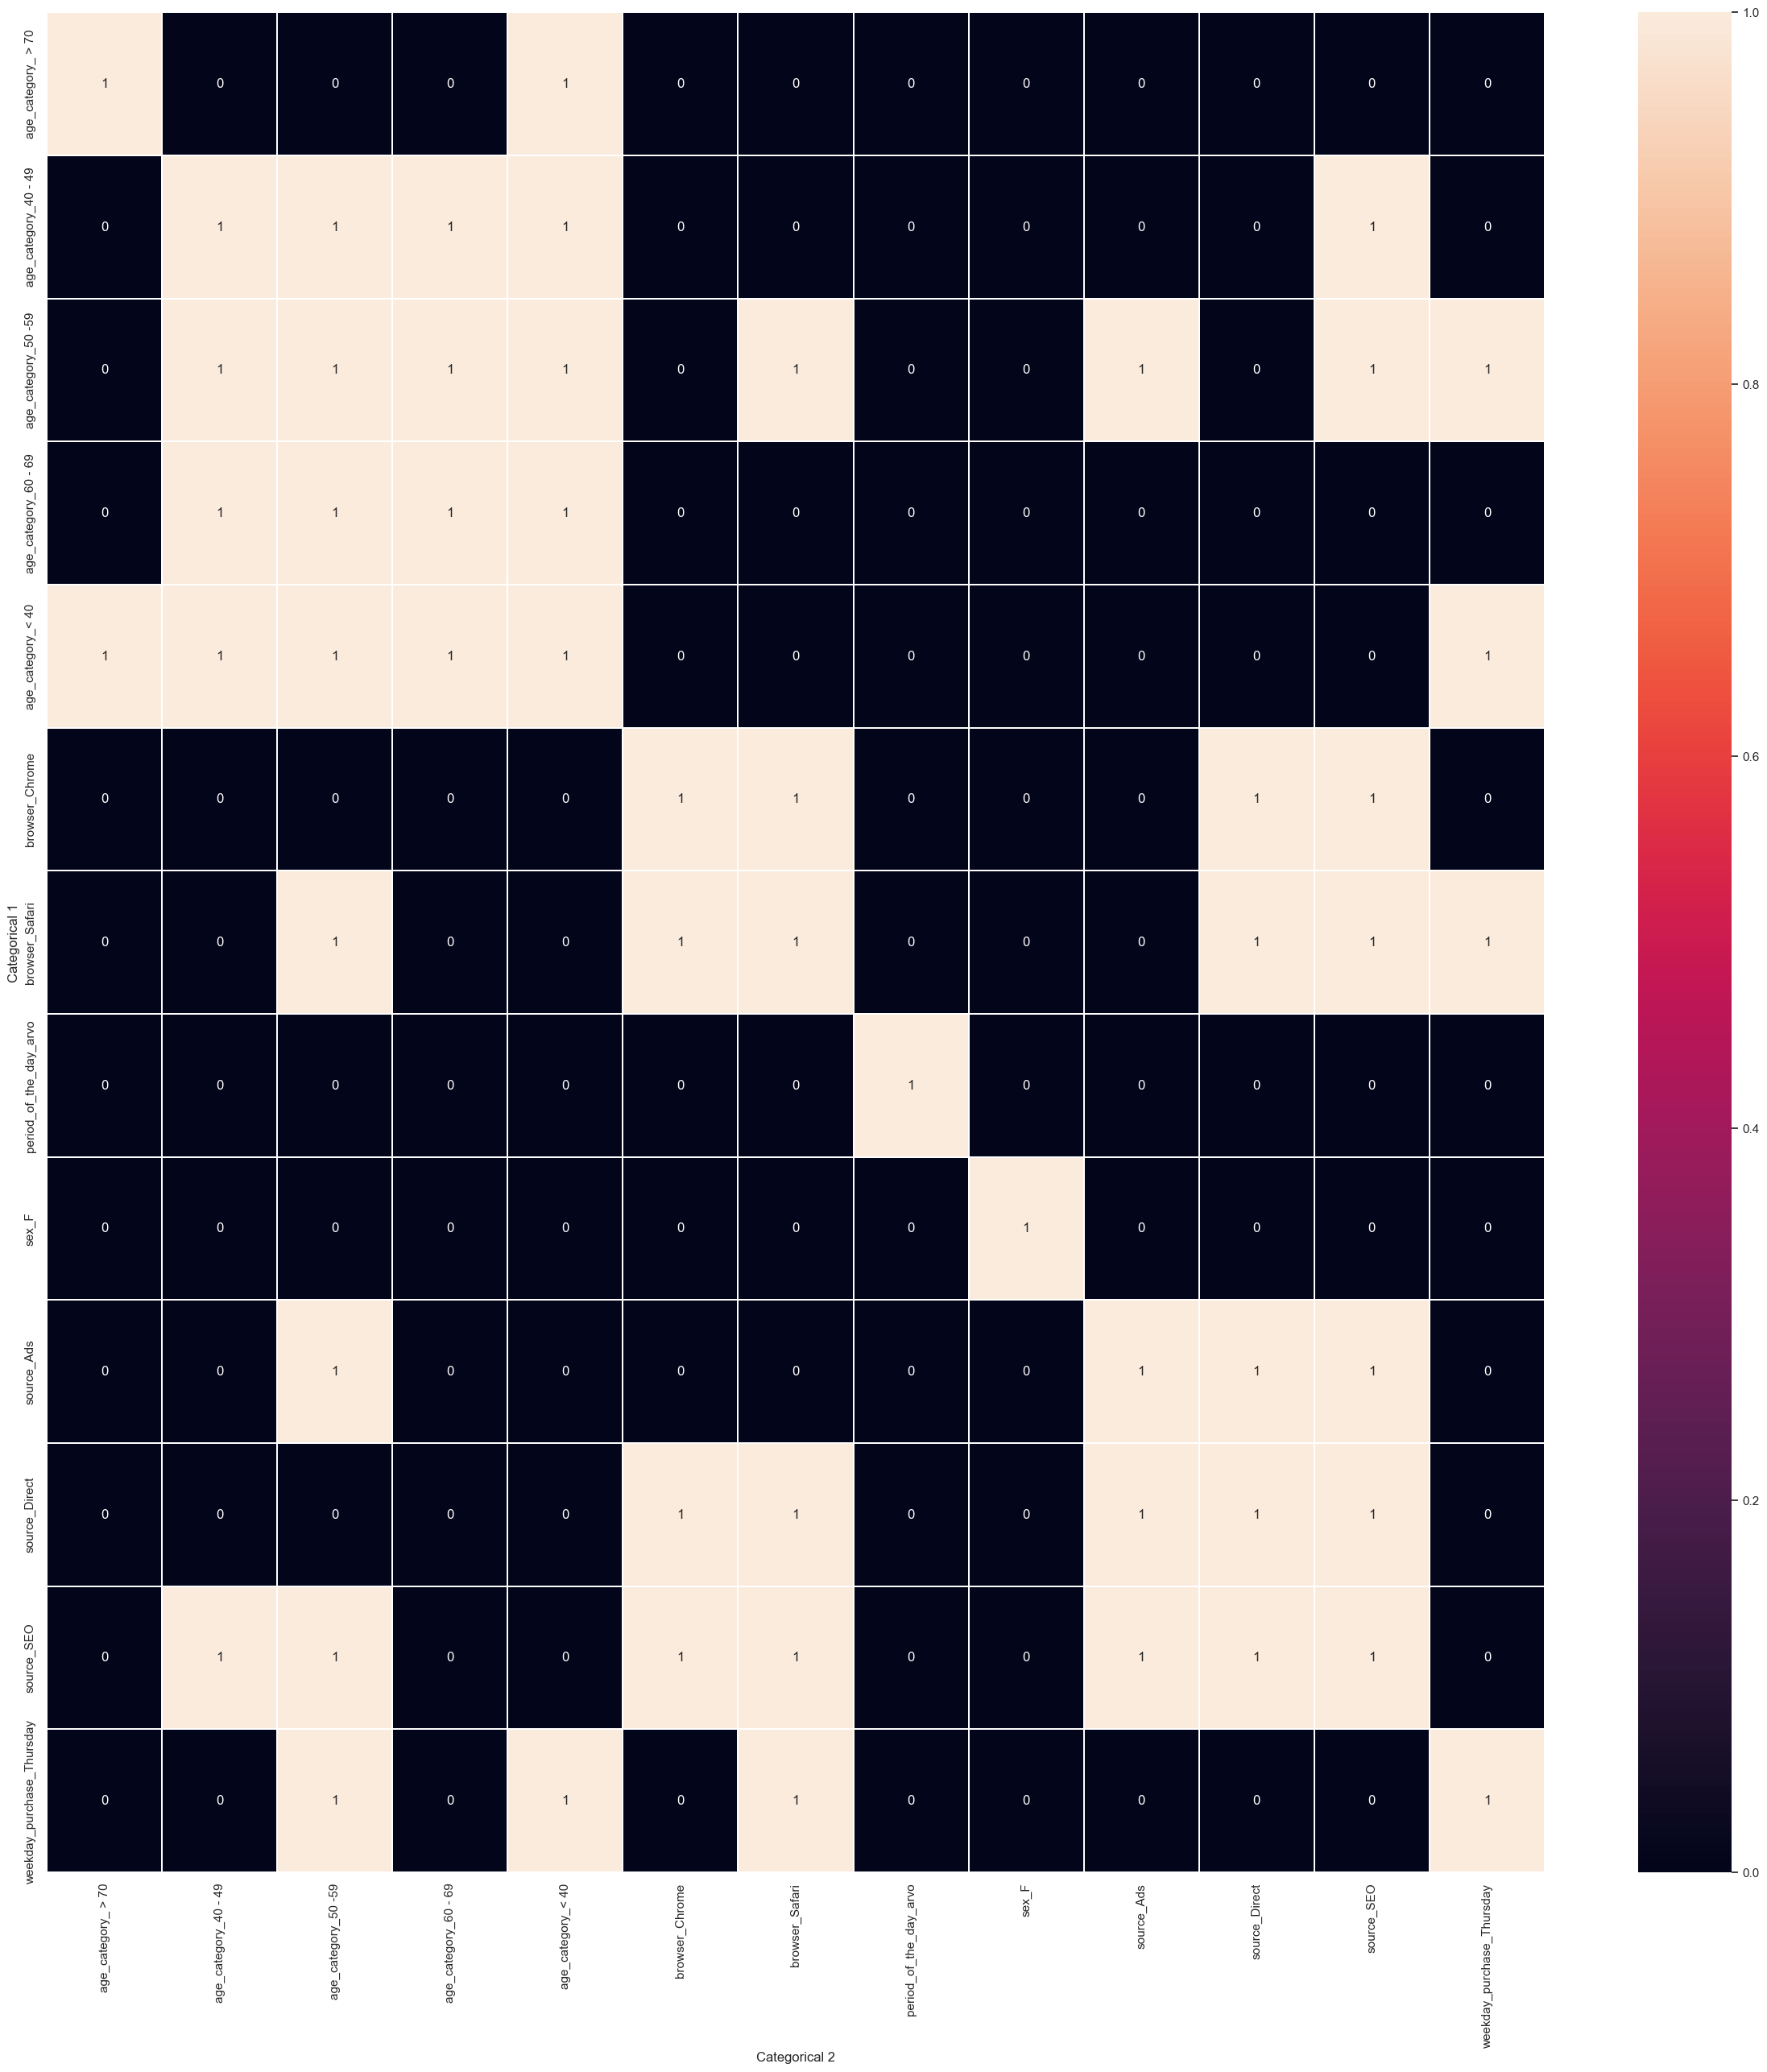

In [72]:
sns.heatmap(round(chisquare.pivot_table(index='Categorical 1', columns='Categorical 2', values='p-value'),2) <= 0.05,
                 annot=True, 
                 linewidths=.05)

The null hypothesis states that there is no relationship between the two variables <br>
With the binary heatmap for chi square test, 1 indicating the rejection of null hypothesis, the categorical variables are correlated between one another.

### Correlation (Num vs Num)

Text(0.5, 1.0, 'Correlation Heatmap (Num vs Num - Correlation Matrix)')

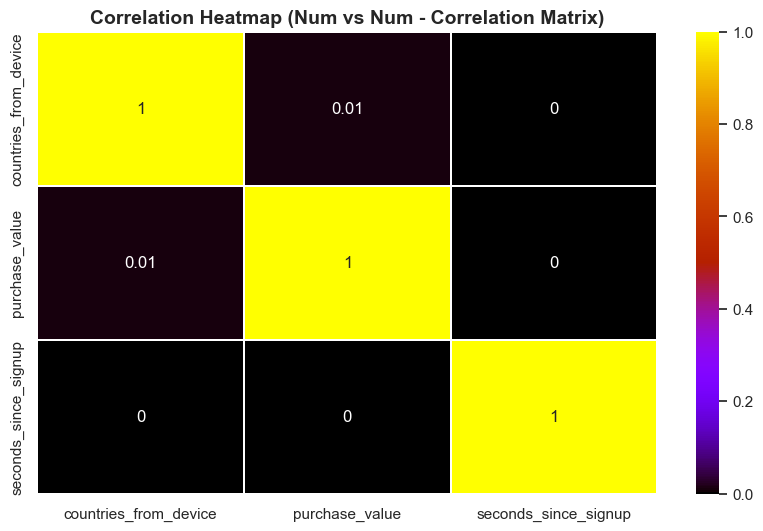

In [73]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
corrMatrix = dataset[num_vars].corr()
sns.heatmap(round(corrMatrix, 2), ax=ax,annot=True, cmap=cmap,linewidths=.05)

plt.title('Correlation Heatmap (Num vs Num - Correlation Matrix)', fontsize=14, fontweight='bold')


From the correlation matrix, the numerical variables are not correlated to one another.

### Anova Test (Cat vs Num)

In [74]:
results = []

for cat in cat_vars:
    for num in num_vars:
        
        candidates = []
        for val in data[cat].unique():
            if len(data[data[cat]==val][num])>0:
                candidates.append(data[data[cat]==val][num])
                
        _, p_val = stats.f_oneway(*candidates)
        results.append((cat, num, p_val))

In [75]:
anova = pd.DataFrame(results, columns=['Categorical', 'Numerical', 'P-value'])
anova.pivot_table(index='Numerical', columns='Categorical')

P-value                       \
Categorical           age_category_ > 70 age_category_40 - 49   
Numerical                                                       
countries_from_device           0.442735             0.549494   
purchase_value                  0.429586             0.031523   
seconds_since_signup            0.842212             0.556712   

                                                                \
Categorical           age_category_50 -59 age_category_60 - 69   
Numerical                                                        
countries_from_device            0.089754             0.936362   
purchase_value                   0.743723             0.826648   
seconds_since_signup             0.282725             0.639719   

                                                                       \
Categorical           age_category_< 40 browser_Chrome browser_Safari   
Numerical                                                               
countries_from_device          0.824131       0.844776       0.912697   
purchase_value                 0.034699       0.090500       0.427408   
seconds_since_signup           0.993261       0.000002       0.000319   

                                                                   \
Categorical           period_of_the_day_arvo     sex_F source_Ads   
Numerical                                                           
countries_from_device               0.452470  0.551148   0.053254   
purchase_value                      0.581404  0.437897   0.864608   
seconds_since_signup                0.012348  0.042767   0.276691   

                                                                          
Categorical           source_Direct source_SEO weekday_purchase_Thursday  
Numerical                                                                 
countries_from_device      0.281114   0.296028                  0.219103  
purchase_value             0.956089   0.900518                  0.032799  
seconds_since_signup       0.553557   0.116090                  0.090526

Text(0.5, 1.0, 'Correlation Heatmap (Num vs Cat - Anova test)')

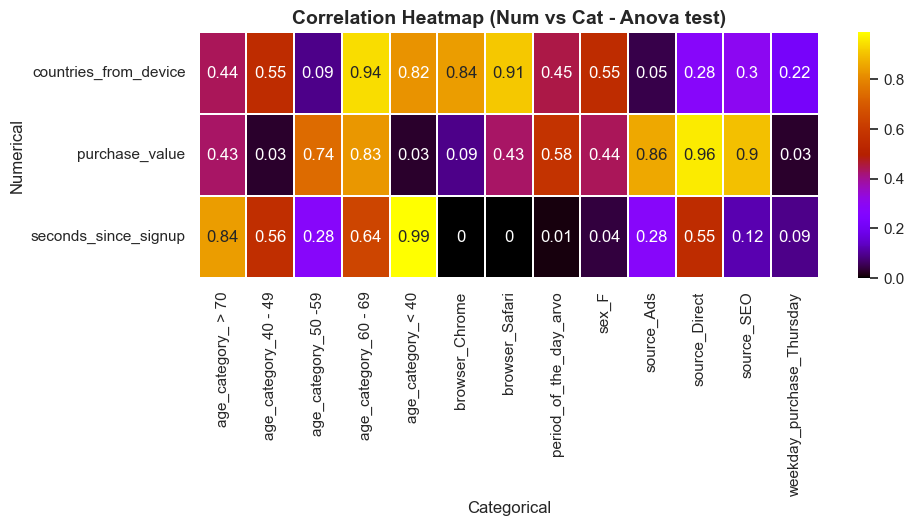

In [78]:
fig, ax = plt.subplots(1,1, figsize=(10,3))

hm = sns.heatmap(round(anova.pivot_table(index='Numerical', columns='Categorical', values='P-value'),2), 
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 cmap=cmap, # Color Map.
                 annot=True, 
                 linewidths=.05)

fig.subplots_adjust(top=0.93)

plt.title('Correlation Heatmap (Num vs Cat - Anova test)', fontsize=14, fontweight='bold')

<AxesSubplot:xlabel='Categorical', ylabel='Numerical'>

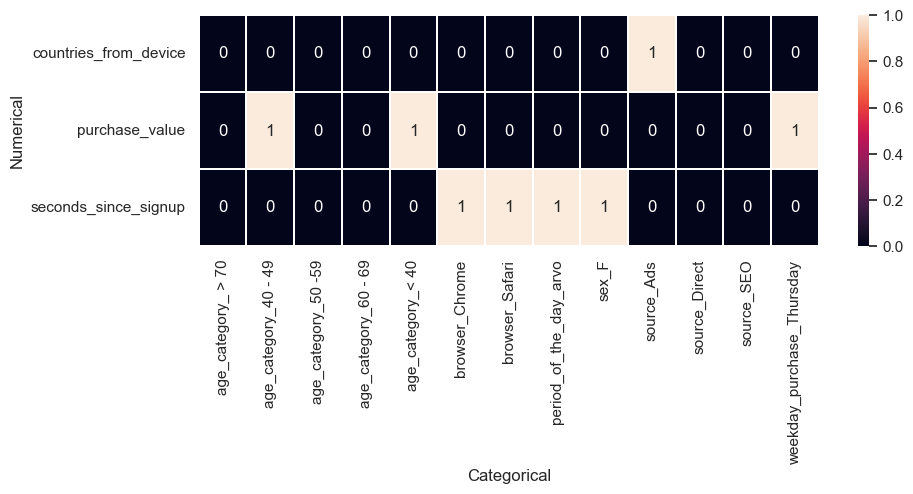

In [81]:
fig, ax = plt.subplots(1,1, figsize=(10,3))

sns.heatmap(round(anova.pivot_table(index='Numerical', columns='Categorical', values='P-value'),2) <= 0.05,
                 ax=ax,           # Axes in which to draw the plot, otherwise use the currently-active Axes.
                 annot=True, 
                 linewidths=.05)

The null hypothesis states that there is no relationship between the two variables <br>
With the binary heatmap for anova test, 1 indicating the rejection of null hypothesis, all the numerical variables are correlated with some of the categorical variables.

`In conclusion, we noticed correlation between the features that we have selected, which we will take account of in the further stages.`

### Train Test Split

In [45]:
final_df_X = data[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'period_of_the_day_arvo',
        'purchase_value', 'seconds_since_signup']]

In [46]:
final_df_y = dataset[['class']]

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df_X, final_df_y, test_size=0.33, random_state=42)

In [48]:
train_df = pd.concat([X_train, y_train], axis=1)

### Up Sampling

In [49]:
from sklearn.utils import resample

not_fraud = train_df[train_df['class']==0]
fraud = train_df[train_df['class']==1]
# upsample minority
fraud_upsampled = resample(fraud,
                          replace=True, # sample with replacement
                          n_samples=len(not_fraud), # match number in majority class
                          random_state=27) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_fraud, fraud_upsampled])

# check new class counts
upsampled['class'].value_counts()

0    91777
1    91777
Name: class, dtype: int64

In [50]:
final_x_train = upsampled[['countries_from_device', 'source_Ads',
       'source_Direct', 'source_SEO', 'browser_Chrome','browser_Safari', 'sex_F', 
       'weekday_purchase_Thursday', 'age_category_ > 70',
       'age_category_40 - 49', 'age_category_50 -59', 'age_category_60 - 69',
       'age_category_< 40', 'period_of_the_day_arvo',
        'purchase_value', 'seconds_since_signup']]

In [51]:
final_y_train = upsampled[['class']]


### Standard Scalar

In [52]:
# Standardize training data using StandardScalar method from sci-kit learn 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() 
stand = scaler.fit(final_x_train)
x_scaled_train = stand.transform(final_x_train)
x_scaled_test = stand.transform(X_test)
# print(pd.DataFrame(x_scaled_train).describe())
# print(pd.DataFrame(x_scaled_test).describe())

### Logistic Regression

#### Cross validation for C value

In [53]:
# define models and parameters
model = LogisticRegression()
solvers = ['saga']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01,]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(x_scaled_train, final_y_train['class'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    # print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (mean, param))

Best: 0.798868 using {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.798868 with: {'C': 100, 'penalty': 'l2', 'solver': 'saga'}
0.798868 with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}
0.798867 with: {'C': 1.0, 'penalty': 'l2', 'solver': 'saga'}
0.798864 with: {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}
0.798833 with: {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}


In [54]:
# define models and parameters
model = LogisticRegression(solver='saga', penalty='l2', C=10)

# fit model
model.fit(x_scaled_train, final_y_train['class'])

# predict model
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     45184
           1       1.00      0.03      0.06      4683

    accuracy                           0.91     49867
   macro avg       0.95      0.52      0.51     49867
weighted avg       0.92      0.91      0.87     49867



c:\Users\J\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [55]:
# print('Train loss:', train_score)
print('Train R2:', r2(final_y_train, model.predict(x_scaled_train)))

# print('Test loss:', test_score)
print('Test R2:', r2(y_test, model.predict(X_test)))

Train R2: -0.11452760495548997
Test R2: -0.06947072400080079


c:\Users\J\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


#### Comparison of Regularization

In [56]:
# define models and parameters
model = LogisticRegression()
# solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
solvers = ['saga']
penalty = ['l1', 'l2']
c_values = [10]
# define grid search
grid = dict(solver=solvers,penalty=penalty, C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc', error_score=0)
grid_result = grid_search.fit(x_scaled_train, final_y_train['class'])
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    # print("%f (%f) with: %r" % (mean, stdev, param))
    print("%f with: %r" % (mean, param))

Best: 0.798868 using {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
0.798868 with: {'C': 10, 'penalty': 'l1', 'solver': 'saga'}
0.798868 with: {'C': 10, 'penalty': 'l2', 'solver': 'saga'}


In [ ]:
0.793064  - 0.791398 


In [57]:
grid_pred = grid_result.predict(X_test)
print(classification_report(y_test, grid_pred))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     45184
           1       1.00      0.03      0.06      4683

    accuracy                           0.91     49867
   macro avg       0.95      0.52      0.51     49867
weighted avg       0.92      0.91      0.87     49867



c:\Users\J\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [58]:
# print('Train loss:', train_score)
print('Train R2:', r2(final_y_train, grid_result.predict(x_scaled_train)))

# print('Test loss:', test_score)
print('Test R2:', r2(y_test, grid_result.predict(X_test)))

Train R2: -0.1145711888599541
Test R2: -0.06947072400080079


c:\Users\J\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
